# 영화 리뷰 평점 예측 모델 구축

## 데이터 전처리

### 필요한 패키지 임포트

In [1]:
import pandas as pd
import re

In [10]:
from keras.datasets import reuters
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding 
from keras.preprocessing import sequence 
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from tensorflow import keras
import numpy as np

### 데이터 가져오기

In [3]:
data = pd.read_excel('./영화목록.xlsx') # data = pd.read_excel('./영화목록3_복구.xlsx')
data.head()

,Unnamed: 0,name,num,review
0,0,명량,10,역대 대명작이라 자부합니다^^
1,1,명량,10,진짜 이건 우리나라 영화계에 한 획을 그을 정도에 명작입니다 우리가 역사를 배워야 ...
2,2,명량,3,"국뽕 범벅, 거품, 스크린독점 관객동원"
3,3,명량,10,초등 고학년 아들과 진도에 다녀온후 같이 봣는데 정말 감사하고 감동이며 죄송스러운 ...
4,4,명량,10,"깊게 숨을 들이쉬고 후하고 내뱉은 뒤, 이 영화를 보아라. 다보고 나서 이틀 뒤에 ..."


### 데이터 확인

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10000 non-null  int64 
 1   name        10000 non-null  object
 2   num         10000 non-null  int64 
 3   review      8930 non-null   object
dtypes: int64(2), object(2)
memory usage: 312.6+ KB


### 결측값 처리

In [5]:
data = data[data['review'].notnull()]
data = data[data['num'].notnull()]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8930 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  8930 non-null   int64 
 1   name        8930 non-null   object
 2   num         8930 non-null   int64 
 3   review      8930 non-null   object
dtypes: int64(2), object(2)
memory usage: 348.8+ KB


In [7]:
data.tail()

,Unnamed: 0,name,num,review
9994,9994,블랙 팬서,10,나의 영원한 왕 영원한 히어로..이제 하늘을 지키기위해 갔다고 생각할래요...와칸다...
9996,9996,블랙 팬서,10,"와칸다의 왕, 그의 죽음은 끝이 아니길.."
9997,9997,블랙 팬서,10,와칸다 포에버!! 당신이 떠났어도 왕국을 지키겠습니다
9998,9998,블랙 팬서,10,처음 볼 때는 그저 재미있는 영화라고 생각을 하였습니다. 그런데 암 투병 중에 촬영...
9999,9999,블랙 팬서,10,R.I.P 채드윅. 영원한 블랙팬서


### 정규표현식

In [8]:
# 특수문자 제거
data['review'] = data['review'].apply(lambda x : re.sub(r'[^ A-Za-z0-9가-힣+]', " ", x))
# data['review'] = data['review'].apply(lambda x : re.sub(r[^ ㄱ-ㅣ가-힣]+', " ", x))
data.tail()

,Unnamed: 0,name,num,review
9994,9994,블랙 팬서,10,나의 영원한 왕 영원한 히어로 이제 하늘을 지키기위해 갔다고 생각할래요 와칸다...
9996,9996,블랙 팬서,10,와칸다의 왕 그의 죽음은 끝이 아니길
9997,9997,블랙 팬서,10,와칸다 포에버 당신이 떠났어도 왕국을 지키겠습니다
9998,9998,블랙 팬서,10,처음 볼 때는 그저 재미있는 영화라고 생각을 하였습니다 그런데 암 투병 중에 촬영...
9999,9999,블랙 팬서,10,R I P 채드윅 영원한 블랙팬서


### data 공백(whitespace)만 있거나 빈 값을 가진 행이 있다면 Null 값으로 변경하도록 하고, Null 값이 존재하는지 확인

In [11]:
data['review'] = data['review'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
data['review'].replace('', np.nan, inplace=True)
print(data.isnull().sum())

Unnamed: 0    0
name          0
num           0
review        9
dtype: int64


C:\Users\lyj\AppData\Local\Temp/ipykernel_7852/1711523902.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['review'] = data['review'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


In [12]:
data.loc[data.review.isnull()][:5]

,Unnamed: 0,name,num,review
225,225,신과함께-죄와 벌,10,NaN
312,312,국제시장,10,NaN
1668,1668,택시운전사,1,NaN
2878,2878,검사외전,8,NaN
3321,3321,캡틴 아메리카: 시빌 워,9,NaN


### 의미 없는 데이터이므로 지우기

In [13]:
data = data.dropna(how = 'any')
print(len(data))

8921


### 데이터 다시 처리하기

In [14]:
data.drop_duplicates(subset = ['review'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
data['review'] = data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
data['review'] = data['review'].str.replace('^ +', "") # 공백은 empty 값으로 변경
data['review'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
data = data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(data))

전처리 후 테스트용 샘플의 개수 : 8627


C:\Users\lyj\AppData\Local\Temp/ipykernel_7852/724760334.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['review'] = data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
C:\Users\lyj\AppData\Local\Temp/ipykernel_7852/724760334.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data['review'] = data['review'].str.replace('^ +', "") # 공백은 empty 값으로 변경


In [15]:
data = data.reset_index(drop = True)
data

,Unnamed: 0,name,num,review
0,0,명량,10,역대 대명작이라 자부합니다
1,1,명량,10,진짜 이건 우리나라 영화계에 한 획을 그을 정도에 명작입니다 우리가 역사를 배워야 ...
2,2,명량,3,국뽕 범벅 거품 스크린독점 관객동원
3,3,명량,10,초등 고학년 아들과 진도에 다녀온후 같이 봣는데 정말 감사하고 감동이며 죄송스러운 ...
4,4,명량,10,깊게 숨을 들이쉬고 후하고 내뱉은 뒤 이 영화를 보아라 다보고 나서 이틀 뒤에 ...
...,...,...,...,...
8622,9994,블랙 팬서,10,나의 영원한 왕 영원한 히어로 이제 하늘을 지키기위해 갔다고 생각할래요 와칸다...
8623,9996,블랙 팬서,10,와칸다의 왕 그의 죽음은 끝이 아니길
8624,9997,블랙 팬서,10,와칸다 포에버 당신이 떠났어도 왕국을 지키겠습니다
8625,9998,블랙 팬서,10,처음 볼 때는 그저 재미있는 영화라고 생각을 하였습니다 그런데 암 투병 중에 촬영...


### X, y 데이터 분할

In [16]:
data_X = data['review']
data_Y = data['num']

In [17]:
data_X.head()

0                                     역대 대명작이라 자부합니다  
1    진짜 이건 우리나라 영화계에 한 획을 그을 정도에 명작입니다 우리가 역사를 배워야 ...
2                                국뽕 범벅  거품  스크린독점 관객동원
3    초등 고학년 아들과 진도에 다녀온후 같이 봣는데 정말 감사하고 감동이며 죄송스러운 ...
4    깊게 숨을 들이쉬고 후하고 내뱉은 뒤  이 영화를 보아라  다보고 나서 이틀 뒤에 ...
Name: review, dtype: object

In [18]:
print(data_X.shape)
print(data_Y.shape)

(8627,)
(8627,)


In [19]:
data_X = data_X.astype(str)

### 형태소 분석

#### Komoran

In [20]:
from konlpy.tag import Komoran

In [21]:
# Komoran 객체 생성하기
komoran = Komoran()

In [22]:
# 불용어 파일
stop = pd.read_csv('./한국어불용어100.txt', sep = '\t', encoding = 'utf-8')

# 불용어 리스트 생성
stopwords = stop['불용어'].tolist()

In [23]:
# 명사만 추출하기
k_pos = []

for data in data_X:
    k_pos_data = komoran.nouns(data)
    
    # 불용어 제거
    result_list = [word for word in k_pos_data if not word in stopwords]
    
    k_pos.append(result_list)

In [24]:
print(len(k_pos))
for pos in k_pos:
    print(pos)

8627
['역대', '명작', '자부']
['이건', '우리나라', '영화', '획', '명작', '역사', '이유', '이유', '영화']
['국', '뽕', '범벅', '거품', '스크린', '독점', '관객', '동원']
['초등', '학년', '아들', '진도', '후', '감사', '감동', '마음']
['숨', '후', '뒤', '영화', '이틀', '뒤', '분', '동안', '조깅', '청국장', '뒤', '영화', '일주일', '뒤', '모두', '잠', '새벽', '불', '영화', '이영화', '한치의', '흠', '완벽', '이순신', '장군', '명량', '해전', '연출', '영화', '감독', '존경']
['낮', '당', '터', '야', '어', '주준']
['배우', '진', '역사', '재료', '루즈', '연출', '스토리', '전개', '인해', '후반']
['수준', '영화', '명작', '대', '정신', '상태', '의심']
['대작']
['이순신', '장군', '감사', '대한민국', '건', '거', '감사']
['나라', '끝', '이순신', '장군', '감사', '사랑', '존경']
['연출', '긴장감', '연기력', '완벽', '역사', '고증', '듯', '다', '이순신', '장군', '내면', '고민', '표현', '플로', '영화']
['이름', '이순신']
['배경', '음악']
['연기', '배경', '가족', '영화', '용인', '약간', '감동']
['국', '뽕', '충만', '돼지', '눈물', '바다']
['국', '뽕', '이순신', '장군', '국', '뽕', '이순신', '장군', '배', '세계', '분이']
['예전', '극장']
['바', '광', '최민식']
['국', '뽕', '감성', '팔', '상업', '영화']
['영화', '말도', '욕', '다', '큐', '영화', '영화로', '전투', '이제', '와서', '장군', '분이', '펄']
['동안', '최민식

['어벤저스', '배', '베']
['아이언맨', '애', '히어로']
['아이언맨', '시리즈', '판', '일부', '인지', '이후', '처음', '극장', '영화', '최고', '영화']
['로', '다', '아이언맨', '아이언맨']
['폭력', '통쾌', '아이언맨', '폭력', '그동안', '영웅', '아무것', '애초', '남자', '여성', '아이언맨', '원래', '영화']
[]
['친구', '아빠', '방패', '친구', '건', '인성', '쓰레기', '녀석']
['마블']
['넘']
['꿀', '존', '캡틴']
['캡틴', '열', '다', '캡틴', '이드', '라', '재질', '토니', '보살']
['첨', '볼', '캡틴', '짜증', '보니', '아이언맨', '버키', '애', '마블', '은', '무한', '반복', '듯']
['각자', '사상', '충돌', '액션', '맛']
['반복', '영화']
['아이언맨']
['캡틴', '아메리카', '훈', '발', '롬', '암']
['자유', '냐', '통제', '냐', '조직', '구성원', '간의', '분열', '대립', '현실', '비판']
[]
['아이언맨', '캡', '버키']
['영화', '엔드', '게임']
['캡틴', '임', '몸', '방패', '하워드', '스타크', '건', '우정', '나부랭이', '거리']
['짜임새', '갈등', '전개', '과정']
['마블', '시리즈', '명작', '아이언맨', '캡틴 아메리카', '라이벌', '구도', '으뜸', '영웅들', '집합', '볼거리', '서사', '액션', '감정', '선', '게', '어벤져스', '라고', '게', '듯']
['캡틴', '아메리카', '윈터', '솔져']
['영웅들', '등장', '결론', '히어로', '간', '이념', '대립', '제재']
['아이언맨']
['성숙', '유아기', '영아', '저능아', '영화']
['키', '마블']
['마지막', '소름']
['캡', '아가',

['호러', '영화', '최고', '걸작', '관객', '기존', '호러', '영화', '흐름', '희생', '허점', '해결', '최고', '해결사', '배신']
['미끼', '물어', '분', '이여']
['영화', '거', '한국', '영화', '수준', '단계', '영화', '영화', '이유', '하나로', '수준', '거', '평생', '신과함께']
['현실', '부분', '가미', '픽션', '흐름', '감상']
['불필요', '칠', '갑', '개연', '스토리', '금', '좀비', '대사', '전달', '동물', '건']
['연기', '주인공', '무지', '팔', '귀인', '결말', '영화']
['간', '의문', '영화', '다', '다운', '스트리밍']
['현혹', '자유']
['관객', '친절', '영화']
['해석', '해석', '나름', '오컬트', '꿀']
['건']
['영화']
['믿음']
['공포', '영화', '안다', '영화', '수작']
['발버둥', '운명', '무력', '근원', '공포', '광기', '시선', '한국', '형', '오컬트', '명작']
['명작']
['홍', '지니', '형', '담', '형', '혼자', '랑', '종', '아니야']
['우아', '영화', '공포', '영화', '완전', '극찬', '밖', '끝', '결과', '예측', '긴장감', '배우', '열연', '최고', '연출', '손', '땀', '리뷰', '최고']
['한국', '영화', '명작', '만큼']
['충격', '재미', '감동', '건', '지도', '장면', '첨삭', '개연', '엔', '장면', '놈', '돈', '사서', '거', '돈', '선택']
['랑', '종', '따', '구로']
['음향', '쪽', '대사', '스토리', '하늘나라', '감', '개봉', '만', '영화', '실제', '시골', '검정고무신', '안나', '법', '거', '사건', '거', '서울', '쪽', '딸', '래미', '감

['영화']
['액션', '연기', '스파이더맨', '성격', '노', '답', '발암', '영화', '돈', '거', '이쯤', '화나', '줄', '영화', '빌', '런', '스파이더맨', '인지']
['시리즈', '최악', '단점', '최강', '장점', '승화']
[]
[]
['거', '예']
['스파이더맨', '팬', '선물', '영화', '스토리', '개연', '부족', '기대']
['마블', '팬', '서비스', '끝판', '왕']
['소름', '영화', '장면']
['명의', '스파이더맨', '영화', '별점']
['만', '만']
['기대', '이상', '거']
['이야기', '반복', '장면', '중간', '중생', '이상', '듯', '기대']
['고블린', '옥', '토', '아', '찌', '토비', '스파', '앤드류스', '파', '빌', '런', '거미', '인간', '스파이더맨', '맘', '졸', '어', '린날']
['빌', '런', '스파이더맨', '기대감', '빵', '폭죽', '급', '정리', '팬', '서비스', '졸', '작']
['영화']
['앤드루', '가필드', '구', '목이', '메이', '목소리']
['작년', '최고', '영화']
['영화', '시작', '닥터 스트레인지', '맛']
['대', '아들', '왕고', '구마', '느낌', '예전', '캐릭터', '어른', '인사', '옆', '옴', '마', '짜증', '느낌', '대인', '옛날', '서로', '의견', '차이', '사이', '누', '군가', '분', '오늘', '행복', '욕심', '선물', '오늘', '동안', '행복']
['스파이더맨', '학', '마블', '이건', '스토리', '연출', '엔드', '게임', '스케일']
['개인', '관람', '포인트', '토비', '맥과이어', '눈빛', '연기', '앤드류 가필드', '톰 홀랜드', '전광판', '연기', '스파이더맨', '액션']
['스파이더맨', '시리즈', '팬', '

### 빈도 분석

In [25]:
from nltk import FreqDist

In [26]:
# 단어 집합(vocabulary) 만들기
word_list = []

# 단어만 추출
for tokens in k_pos:
    for t in tokens:
        word_list.append(t)

In [27]:
fd_names = FreqDist(word_list)
fd_names.most_common(500) # 상위 500개 검색

[('영화', 4086),
 ('연기', 861),
 ('최고', 682),
 ('스토리', 602),
 ('거', 573),
 ('배우', 547),
 ('감동', 503),
 ('액션', 351),
 ('평점', 322),
 ('장면', 311),
 ('한국', 308),
 ('인생', 292),
 ('연출', 289),
 ('편', 282),
 ('명작', 272),
 ('마지막', 258),
 ('감독', 238),
 ('듯', 234),
 ('역사', 233),
 ('눈물', 219),
 ('재미', 216),
 ('처음', 216),
 ('건', 208),
 ('작품', 199),
 ('만', 195),
 ('느낌', 194),
 ('시리즈', 193),
 ('감사', 184),
 ('분', 184),
 ('완벽', 182),
 ('마블', 175),
 ('현실', 150),
 ('몰입', 150),
 ('개봉', 146),
 ('내용', 146),
 ('기대', 144),
 ('기억', 142),
 ('부분', 139),
 ('이해', 134),
 ('스파이더맨', 134),
 ('캐릭터', 132),
 ('강동원', 131),
 ('보니', 130),
 ('끝', 129),
 ('게', 129),
 ('주인공', 125),
 ('마음', 124),
 ('자체', 122),
 ('제일', 122),
 ('볼', 119),
 ('대사', 115),
 ('다', 114),
 ('추천', 114),
 ('대한민국', 111),
 ('나라', 110),
 ('가족', 108),
 ('필요', 107),
 ('남', 107),
 ('이야기', 107),
 ('굿', 105),
 ('연기력', 104),
 ('대', 103),
 ('중간', 103),
 ('넘', 102),
 ('영화관', 102),
 ('당시', 100),
 ('존', 100),
 ('시대', 100),
 ('극장', 98),
 ('인간', 97),
 ('가슴', 95),
 ('오랜만', 

In [28]:
dict_fd = fd_names.items()

for dict in dict_fd:
    key = dict[0]
    val = dict[1]
    if val < 20: # 빈도수 20번 미만인거 지우기,,(상위 500개로 검색 결과 빈도수 20번 이었음.)
        for pos in k_pos:
            if key in pos:
                pos.remove(key)

In [29]:
len(k_pos)

8627

In [30]:
res = []
for i, x in enumerate(k_pos):
    print(i, x)
    if len(x) == 0:
        res.append(i)
        
print(res)
print(len(res))

0 ['역대', '명작']
1 ['이건', '우리나라', '영화', '명작', '역사', '이유', '이유', '영화']
2 ['국', '뽕', '관객']
3 ['아들', '후', '감사', '감동', '마음']
4 ['후', '뒤', '영화', '뒤', '분', '동안', '뒤', '영화', '뒤', '모두', '불', '영화', '이영화', '완벽', '이순신', '장군', '연출', '영화', '감독', '존경']
5 ['당', '어']
6 ['배우', '역사', '연출', '스토리', '전개', '후반']
7 ['수준', '영화', '명작', '대', '정신']
8 ['대작']
9 ['이순신', '장군', '감사', '대한민국', '건', '거', '감사']
10 ['나라', '끝', '이순신', '장군', '감사', '사랑', '존경']
11 ['연출', '긴장감', '연기력', '완벽', '역사', '고증', '듯', '다', '이순신', '장군', '표현', '영화']
12 ['이름', '이순신']
13 ['배경', '음악']
14 ['연기', '배경', '가족', '영화', '감동']
15 ['국', '뽕', '눈물']
16 ['국', '뽕', '이순신', '장군', '국', '뽕', '이순신', '장군', '배', '세계']
17 ['예전', '극장']
18 ['바']
19 ['국', '뽕', '감성', '팔', '영화']
20 ['영화', '욕', '다', '영화', '영화로', '전투', '이제', '장군']
21 ['동안', '연기', '건', '부분', '존재']
22 ['영웅', '이순신', '장군', '영화', '주제', '조금', '다음', '이순신', '장군', '소재', '영화', '기대', '영화', '개봉', '당시', '우리나라', '기대']
23 ['이순신', '인생', '자체', '영화']
24 ['전체', '위', '냐']
25 ['이순신', '장군', '영화', '감독', '후', '속편', '후', '속편', '완

1673 ['영', '영화', '이건']
1674 ['후반부', '코믹', '요소', '욕', '이민기', '시절', '매력']
1675 ['평점', '테러']
1676 ['배우', '연기', '부분', '부분', '요소']
1677 ['옛날']
1678 ['연출', '실화', '냐', '나이', '보니', '이건']
1679 ['억지', '웃음', '억지', '감동', '미', '감상', '포인트']
1680 []
1681 ['짜증', '신파극']
1682 ['최고', '의미', '영화']
1683 ['건', '처음']
1684 ['한국', '영화', '예']
1685 ['영화', '영화', '최악', '스토리', '당시', '영화']
1686 ['이민기', '주인공']
1687 ['시민', '눈물']
1688 ['후회', '나라', '분', '거', '영화']
1689 ['민주화', '영화']
1690 ['영화']
1691 ['가슴', '영화', '대한민국', '국민', '국민', '나라', '순간', '항', '대한민국', '이다', '항', '대한민국', '국민', '국민']
1692 []
1693 ['볼', '눈물']
1694 ['감동', '영화', '눈물']
1695 ['기억', '영화', '가슴']
1696 ['영화', '필요']
1697 ['넘']
1698 ['대통령', '당시', '정치', '이해', '요즘']
1699 ['영화']
1700 []
1701 ['욕']
1702 ['영화']
1703 ['영화']
1704 ['분', '존경']
1705 ['밖']
1706 ['노', '눈물']
1707 ['인생', '영화']
1708 ['국가']
1709 ['정치', '개인', '존경', '분']
1710 ['빨갱이', '북한', '정치']
1711 []
1712 ['인생', '영화']
1713 ['노', '무']
1714 ['감사', '대통령']
1715 ['감동', '가슴', '영화', '시대', '아픔', '만', '세상', '대한민국', '대한

3322 ['소재', '코미디', '감동', '캐릭터']
3323 ['완전', '명작']
3324 ['처음', '끝', '틈', '재미', '감동', '행복']
3325 ['거', '기억', '어', '역대', '급', '이다']
3326 ['박보영', '연기', '최고']
3327 ['오랜만', '봄', '예전', '후', '영화', '극장']
3328 ['영화', '과']
3329 ['한국', '가족']
3330 ['평점', '영화', '이유']
3331 ['극장', '오늘']
3332 ['스토리']
3333 ['스타일', '촌', '도', '영화', '재미', '로', '길', '아크', '로', '타워']
3334 ['한국', '가족', '코미디', '듯']
3335 ['만', '평가', '소재', '영화']
3336 ['절대', '소재', '그때', '시절', '작품', '박보영', '이때', '리']
3337 []
3338 ['남', '스토리']
3339 ['영화로', '개봉', '영화로', '만큼', '영화', '연출']
3340 ['박보영', '매력', '재미', '편']
3341 ['감독', '포인트', '영화', '감독', '스토리', '매력', '캐릭터', '스토리', '작품']
3342 ['레전드', '영화']
3343 ['영화', '여운', '재밌는 영화', '다', '박보영', '흥행', '얘기', '박보영', '과속스캔들', '거']
3344 ['영화', '박보영', '케미', '영화', '평론가', '평', '관객', '평', '이유', '영화']
3345 ['작품', '코믹', '감동', '재미', '여운', '명작', '관객']
3346 ['영화']
3347 ['보니', '감동', '인생', '영화']
3348 []
3349 ['인생', '영화', '넘']
3350 ['인생', '영화', '감정']
3351 ['감동', '재미', '한국', '영화']
3352 ['볼', '영화']
3353 ['신파', '가족', '코믹', '영

4657 ['영화']
4658 ['영화']
4659 ['꿀', '평점']
4660 ['이번', '아들', '등장', '가족', '배우', '연기', '스토리', '액션', '최고']
4661 ['평점', '애', '이상', '이하', '배우', '액션']
4662 ['한국', '영화', '긴장감', '초반', '중반', '장면', '하정우', '연기', '영화', '연기자', '대사', '입', '오물', '짜증', '몰입']
4663 ['연기']
4664 ['액션', '듯']
4665 ['영화', '액션', '결말']
4666 ['영화', '영상미', '스토리', '요즘', '영화', '수준']
4667 ['영화', '평점', '한국', '영화', '영화', '감독', '배우', '모두', '고생']
4668 []
4669 ['평점']
4670 ['영화', '점수', '작품']
4671 ['기대', '이상', '다', '연기', '감']
4672 ['영화관', '느낌', '간', '시리즈']
4673 ['액션', '맘', '대', '발', '대', '우지', '라고']
4674 ['긴장감', '전개', '구성', '배우', '연기', '영화']
4675 ['그때', '후회', '한국', '첩보', '액션', '대작', '강']
4676 ['인생', '영화', '캐스팅', '연기', '연출', '액션', '대작', '눈', '평점']
4677 ['대사', '거', '공감', '대사', '영화', '대작']
4678 ['영화', '영화']
4679 ['거', '볼', '이병헌', '필요', '강동원', '연기']
4680 ['강동원', '이병헌']
4681 ['우리나라', '영화']
4682 ['물', '영화', '요즘', '범죄', '소재', '나름', '소재', '스토리', '스타일', '나라', '추천', '한국', '영화', '발전', '해', '범죄', '스릴러', '영화', '음']
4683 ['영화', '요즘']
4684 ['보니']
4685 ['부

6327 []
6328 ['전우치']
6329 ['강동원', '연기']
6330 ['요', '영화', '영화']
6331 ['개봉', '듯', '영화']
6332 ['요즘', '한국', '영화']
6333 ['평점', '후반', '초반']
6334 ['전우치', '놈', '머리', '동안', '히어로']
6335 ['도', '감독', '영화', '마음', '우리나라', '스토리', '한편']
6336 ['정']
6337 ['전우치', '처음', '강', '매력']
6338 ['전우치', '액션', '감독', '오락', '감독', '조연', '억지', '면', '강동원', '영화']
6339 ['영화', '엽기', '재밌는 영화', '연출', '후', '전개', '충격']
6340 ['처음', '액션', '배우', '눈', '코로나', '세대', '시', '보니', '소름', '인류', '라고', '소름', '코로나', '아', '욕', '무']
6341 ['오락', '액션', '영화로', '영화', '영화']
6342 ['주인공']
6343 ['기대', '현실', '조금', '부분', '몰입', '감', '장면', '킬링타임']
6344 ['연기력', '아버지', '거']
6345 ['영화', '후반부', '배경', '극', '작품']
6346 ['처음', '끝', '몰입', '공주']
6347 ['급', '액션', '조금', '과']
6348 []
6349 ['악당', '현실', '영화']
6350 ['역대', '최고', '영화']
6351 []
6352 []
6353 ['스토리', '연출']
6354 ['맘', '영화', '티', '공주', '캐스팅', '조연', '급']
6355 ['시']
6356 []
6357 ['우', '가슴', '영화', '진짜', '영화', '자', '강', '추']
6358 ['기대', '스토리']
6359 ['현실', '영화', '액션', '영화로', '만']
6360 ['역사']
6361 ['연기', '매력', '최고']
6

8228 ['히어로']
8229 ['제가', '히어로', '추천']
8230 ['마블', '영화', '스토리', '다음', '영화']
8231 ['마블', '최고', '걸작', '임']
8232 ['평점', '알바', '새끼', '티']
8233 []
8234 ['마블']
8235 ['코믹', '마블']
8236 ['앤트맨', '영화', '영화', '오락', '영화', '임', '후반부', '세계', '영화']
8237 ['노', '듯']
8238 ['넘']
8239 ['마블', '시리즈', '마지막', '영상', '소름']
8240 ['재밌는 영화']
8241 ['스토리', '개연', '느낌', '편']
8242 ['탑', '졸']
8243 ['틈']
8244 ['작품', '기']
8245 ['고생', '거', '스토리', '연출', '수준', '마블', '급', '딸', '딸', '박사', '딸', '위']
8246 ['전작', '이번', '체험', '마블', '덕', '히어로', '영화']
8247 ['다음', '편', '게']
8248 []
8249 ['친구', '꿀', '이랑']
8250 []
8251 ['만']
8252 ['나이']
8253 []
8254 ['마블', '영화', '제일', '이야기', '히어로', '코미디', '마지막', '엔드', '게임', '영화', '기억', '엔드', '게임', '듯']
8255 ['기억', '게']
8256 ['킬링타임', '영화', '평점']
8257 ['영화']
8258 []
8259 ['마블', '라고']
8260 ['재미']
8261 []
8262 ['편', '작품', '엔드', '게임', '떡', '밥', '영화', '만', '가치']
8263 ['빌', '런', '역대', '히어로', '물']
8264 ['항']
8265 ['볼', '오락', '영화', '라고']
8266 ['줄']
8267 ['이야기', '거지', '캡틴', '마블', '블랙', '팬', '마블', '편']
8268 ['오오', 

#### 빈값 지우기

In [31]:
print(len(k_pos))
print(data_Y.shape)

8627
(8627,)


In [32]:
k_pos = np.asarray(k_pos)
data_Y = np.asarray(data_Y)

In [33]:
k_pos = np.delete(k_pos, res, axis = 0)
data_Y = np.delete(data_Y, res, axis = 0)

In [34]:
k_pos.tolist()

[['역대', '명작'],
 ['이건', '우리나라', '영화', '명작', '역사', '이유', '이유', '영화'],
 ['국', '뽕', '관객'],
 ['아들', '후', '감사', '감동', '마음'],
 ['후',
  '뒤',
  '영화',
  '뒤',
  '분',
  '동안',
  '뒤',
  '영화',
  '뒤',
  '모두',
  '불',
  '영화',
  '이영화',
  '완벽',
  '이순신',
  '장군',
  '연출',
  '영화',
  '감독',
  '존경'],
 ['당', '어'],
 ['배우', '역사', '연출', '스토리', '전개', '후반'],
 ['수준', '영화', '명작', '대', '정신'],
 ['대작'],
 ['이순신', '장군', '감사', '대한민국', '건', '거', '감사'],
 ['나라', '끝', '이순신', '장군', '감사', '사랑', '존경'],
 ['연출', '긴장감', '연기력', '완벽', '역사', '고증', '듯', '다', '이순신', '장군', '표현', '영화'],
 ['이름', '이순신'],
 ['배경', '음악'],
 ['연기', '배경', '가족', '영화', '감동'],
 ['국', '뽕', '눈물'],
 ['국', '뽕', '이순신', '장군', '국', '뽕', '이순신', '장군', '배', '세계'],
 ['예전', '극장'],
 ['바'],
 ['국', '뽕', '감성', '팔', '영화'],
 ['영화', '욕', '다', '영화', '영화로', '전투', '이제', '장군'],
 ['동안', '연기', '건', '부분', '존재'],
 ['영웅',
  '이순신',
  '장군',
  '영화',
  '주제',
  '조금',
  '다음',
  '이순신',
  '장군',
  '소재',
  '영화',
  '기대',
  '영화',
  '개봉',
  '당시',
  '우리나라',
  '기대'],
 ['이순신', '인생', '자체', '영화'],
 ['전체', '위', '냐']

In [35]:
len(k_pos)

7889

In [36]:
data_Y.shape

(7889,)

### Tokenizer

In [37]:
from keras.preprocessing.text import Tokenizer 

# tokenizer = Tokenizer(oov_token = "<oov>") 
tokenizer = Tokenizer()  
tokenizer.fit_on_texts(k_pos)
sequences = tokenizer.texts_to_sequences(k_pos)

In [38]:
len(sequences)

7889

In [39]:
print(sequences)

[[184, 15], [85, 95, 1, 15, 19, 92, 92, 1], [217, 218, 100], [248, 101, 28, 7, 47], [101, 132, 1, 132, 29, 198, 132, 1, 132, 348, 459, 1, 86, 30, 208, 191, 13, 1, 17, 332], [460, 173], [6, 19, 13, 4, 82, 365], [73, 1, 15, 62, 281], [366], [208, 191, 28, 54, 23, 5, 28], [55, 44, 208, 191, 28, 98, 332], [13, 102, 61, 30, 19, 398, 18, 52, 208, 191, 87, 1], [461, 208], [224, 133], [2, 224, 56, 1, 7], [217, 218, 20], [217, 218, 208, 191, 217, 218, 208, 191, 128, 179], [333, 69], [367], [217, 218, 185, 462, 1], [1, 209, 52, 1, 93, 269, 230, 191], [198, 2, 23, 38, 270], [231, 208, 191, 1, 317, 305, 163, 208, 191, 125, 1, 36, 1, 34, 66, 95, 36], [208, 12, 48, 1], [249, 148, 368], [208, 191, 1, 17, 101, 381, 101, 381, 610], [114, 208, 191, 399], [92, 1, 48, 209, 25, 38, 6, 2, 269, 258, 532, 19, 180, 25], [1], [11, 3, 1, 71], [108, 217, 218, 208, 191, 1, 157, 1], [1], [192, 134, 103, 208, 71, 208], [1, 25, 9], [1, 199, 349, 208, 191, 193, 297, 12, 1], [111, 1, 1, 219, 83, 11, 1, 218, 21, 334, 38

In [40]:
word_index = tokenizer.word_index
print(word_index)
print(len(word_index))

{'영화': 1, '연기': 2, '최고': 3, '스토리': 4, '거': 5, '배우': 6, '감동': 7, '액션': 8, '평점': 9, '장면': 10, '한국': 11, '인생': 12, '연출': 13, '편': 14, '명작': 15, '마지막': 16, '감독': 17, '듯': 18, '역사': 19, '눈물': 20, '재미': 21, '처음': 22, '건': 23, '작품': 24, '만': 25, '느낌': 26, '시리즈': 27, '감사': 28, '분': 29, '완벽': 30, '마블': 31, '현실': 32, '몰입': 33, '개봉': 34, '내용': 35, '기대': 36, '기억': 37, '부분': 38, '이해': 39, '스파이더맨': 40, '캐릭터': 41, '강동원': 42, '보니': 43, '끝': 44, '게': 45, '주인공': 46, '마음': 47, '자체': 48, '제일': 49, '볼': 50, '대사': 51, '다': 52, '추천': 53, '대한민국': 54, '나라': 55, '가족': 56, '필요': 57, '남': 58, '이야기': 59, '굿': 60, '연기력': 61, '대': 62, '중간': 63, '넘': 64, '영화관': 65, '당시': 66, '존': 67, '시대': 68, '극장': 69, '인간': 70, '가슴': 71, '오랜만': 72, '수준': 73, '아이언맨': 74, '눈': 75, '꿀': 76, '작': 77, '모습': 78, '이상': 79, '완전': 80, '개연': 81, '전개': 82, '시작': 83, '애': 84, '이건': 85, '이영화': 86, '표현': 87, '히어로': 88, '영상미': 89, '줄': 90, '결말': 91, '이유': 92, '영화로': 93, '감': 94, '우리나라': 95, '급': 96, '이병헌': 97, '사랑': 98, '매력': 99, '관객': 100, '후': 

In [41]:
max_len = 0
for l in sequences:
    if len(l) >= max_len:
        max_len = len(l)
print(max_len)

85


In [42]:
import matplotlib.pyplot as plt

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 4.660666751172519


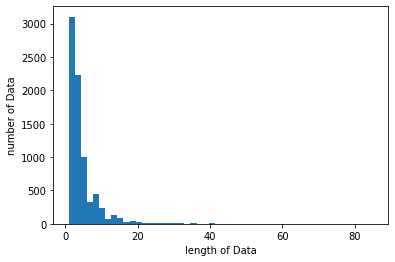

In [43]:
print('리뷰의 최대 길이 : {}'.format(max_len))
print('리뷰의 평균 길이 : {}'.format(sum(map(len, sequences)) / len(sequences))) 

plt.hist([len(s) for s in sequences], bins = 50)
plt.xlabel('length of Data') 
plt.ylabel('number of Data') 
plt.show()

In [44]:
from keras.datasets import reuters 
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding 
from keras.preprocessing import sequence 
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils

In [45]:
print(np.min(data_Y))
print(np.max(data_Y))

1
10


In [46]:
print("max_len : ", max_len)

max_len :  85


In [47]:
X = pad_sequences(sequences, maxlen = 6, truncating = 'post')
y = np_utils.to_categorical(data_Y)

In [48]:
X

array([[  0,   0,   0,   0, 184,  15],
       [ 85,  95,   1,  15,  19,  92],
       [  0,   0,   0, 217, 218, 100],
       ...,
       [  0,   0,   0,   0,   0, 358],
       [ 22,   1, 303,  71,  31,  98],
       [  0,   0,   0,   0, 483, 129]])

In [49]:
print(y)

[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [50]:
print(X.shape)
print(y.shape)

(7889, 6)
(7889, 11)


### 훈련/테스트용 데이터 분할

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 777, stratify = y)

In [53]:
from tensorflow.keras.utils import to_categorical

In [54]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
# y_train = np.asarray(to_categorical(y_train))
# y_test = np.asarray(to_categorical(y_test))
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [55]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [56]:
# 0번째 지우기
y_train = y_train[:, 1:]
print(y_train)

y_test = y_test[:, 1:]
print(y_test)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [57]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6311, 6)
(6311, 10)
(1578, 6)
(1578, 10)


In [335]:
X_train

array([[130,  83,  40, 103, 376,  43],
       [  0,   6,  61,   4, 359,   1],
       [ 50, 105,  85,  87, 106, 367],
       ...,
       [  0,   0,   0,   1, 464,   1],
       [ 23,   3,   6,  13,  44,   5],
       [  0,   0,   0,   0,   0,   6]])

## 모델 구축

### 인공신경망을 제작합니다.

In [336]:
from tensorflow.keras.layers import Dense, GRU, Embedding

In [337]:
embedding_dim = 6
hidden_units = 512

In [338]:
vocab_size = len(word_index)
print(vocab_size)

1388


#### LSTM -> GRU

In [397]:
model = Sequential()
model.add(Embedding(vocab_size + 1, embedding_dim))
model.add(GRU(hidden_units))
# model.add(LSTM(6))
model.add(Dense(10, activation = 'softmax'))

#### 컴파일

In [398]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy',  metrics = ['accuracy'])

#### 신경망 학습시키기

In [399]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

In [400]:
history = model.fit(X_train, y_train, epochs = 6,
                   validation_data = (X_test, y_test),
                   callbacks = [early_stop])

Epoch 1/6
198/198 [==============================] - 6s 24ms/step - loss: 1.4797 - accuracy: 0.6023 - val_loss: 1.3931 - val_accuracy: 0.6046
Epoch 2/6
198/198 [==============================] - 4s 21ms/step - loss: 1.3582 - accuracy: 0.6089 - val_loss: 1.3652 - val_accuracy: 0.6147
Epoch 3/6
198/198 [==============================] - 5s 23ms/step - loss: 1.3170 - accuracy: 0.6153 - val_loss: 1.3467 - val_accuracy: 0.6160
Epoch 4/6
198/198 [==============================] - 4s 22ms/step - loss: 1.2964 - accuracy: 0.6199 - val_loss: 1.4189 - val_accuracy: 0.6160
Epoch 5/6
198/198 [==============================] - 4s 22ms/step - loss: 1.2863 - accuracy: 0.6230 - val_loss: 1.3503 - val_accuracy: 0.6134
Epoch 6/6
198/198 [==============================] - 4s 21ms/step - loss: 1.2779 - accuracy: 0.6235 - val_loss: 1.3509 - val_accuracy: 0.6204


### 모델 성능 그래프로 출력

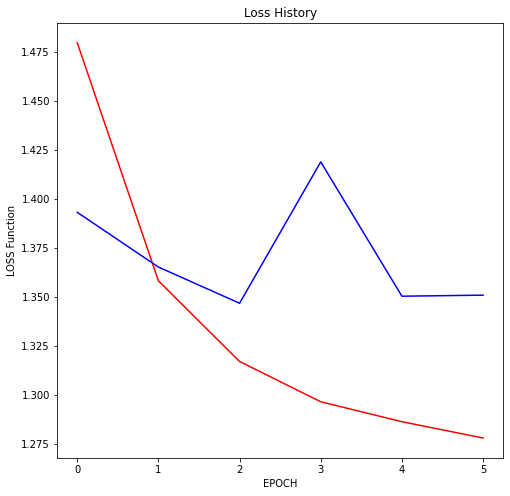

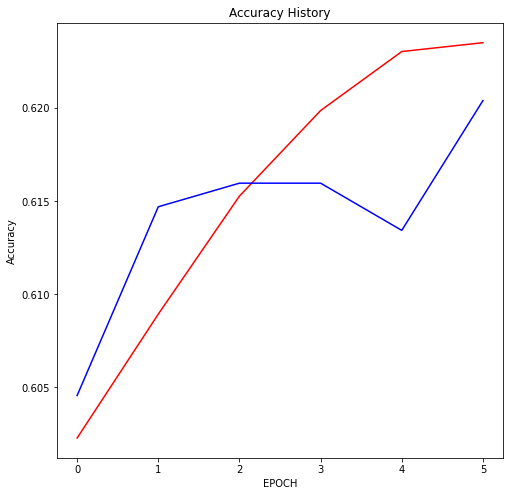

In [403]:
train_history = history.history["loss"]
validation_history = history.history["val_loss"]
fig = plt.figure(figsize=(8, 8))
plt.title("Loss History")
plt.xlabel("EPOCH")
plt.ylabel("LOSS Function")
plt.plot(train_history, "red")
plt.plot(validation_history, 'blue')
# fig.savefig("train_history.png")

train_history = history.history["accuracy"]
validation_history = history.history["val_accuracy"]
fig = plt.figure(figsize=(8, 8))
plt.title("Accuracy History")
plt.xlabel("EPOCH")
plt.ylabel("Accuracy")
plt.plot(train_history, "red")
plt.plot(validation_history, 'blue')
# fig.savefig("accuracy_history.png")

In [223]:
model.save('test_model.h5')

In [346]:
model.evaluate(X_test, y_test)[1]

50/50 [==============================] - 0s 6ms/step - loss: 1.3715 - accuracy: 0.6204


0.6204055547714233

## 평점 테스트

In [349]:
text_list = []

In [350]:
text_list.append("한 마디로 ‘치유’의 과정") # 8점
text_list.append("감동입니다..너무 재미있어용") # 걍 내가 쓴거
text_list.append("최악 !! 다신 안본다.") # 최악 들어간거 1점이었던듯,,,
text_list.append("처음엔 좋았으나 갈수록 보기거북함") # 5점
text_list.append("사형수는 개뿔, 죄없는 애들 속여서 끌고간거라고! 유족들은 억울함도 못풀었는데….이런식으로 팔아먹었어야 했냐? 감독 진짜 양심 터졌구나.") # 1점

In [351]:
# 명사만 추출하기
text_list_pos = []

for text in text_list:
    text_list_data = komoran.nouns(text)
    
    # 불용어 제거
    result_list = [word for word in text_list_data if not word in stopwords]
    
    text_list_pos.append(result_list)

In [352]:
text_list_pos

[['마디', '치유', '과정'],
 ['감동'],
 ['최악', '!!'],
 ['처음', '보기', '거북'],
 ['사형수', '개뿔', '죄', '애', '고간', '거', '유족', '식', '감독', '양심']]

In [353]:
sequences_test = tokenizer.texts_to_sequences(text_list_pos)
sequences_test

[[374], [7], [121], [22], [886, 84, 5, 731, 220, 17]]

In [354]:
sequences_test = pad_sequences(sequences_test, maxlen = 6)
sequences_test

array([[  0,   0,   0,   0,   0, 374],
       [  0,   0,   0,   0,   0,   7],
       [  0,   0,   0,   0,   0, 121],
       [  0,   0,   0,   0,   0,  22],
       [886,  84,   5, 731, 220,  17]])

In [355]:
res_test = model.predict(sequences_test)
res_test

array([[2.99953930e-02, 1.62449833e-02, 2.20267801e-03, 1.59081109e-02,
        9.01206490e-03, 2.82435417e-02, 3.62185203e-02, 7.80075192e-02,
        6.22022673e-02, 7.21964896e-01],
       [6.04593288e-03, 3.13408137e-03, 5.23763301e-04, 4.80752345e-03,
        2.65386538e-03, 9.01611429e-03, 1.23556638e-02, 3.23352776e-02,
        3.94872725e-02, 8.89640510e-01],
       [2.81390429e-01, 1.85722604e-01, 1.57237798e-02, 5.82490526e-02,
        3.77905145e-02, 8.76219794e-02, 9.91368070e-02, 1.28704965e-01,
        3.46192718e-02, 7.10405856e-02],
       [2.49536242e-02, 1.41818263e-02, 2.05267034e-03, 1.46063324e-02,
        8.55957344e-03, 2.59821638e-02, 3.37130092e-02, 7.35521615e-02,
        6.06097467e-02, 7.41788805e-01],
       [1.48358509e-01, 1.12034045e-01, 3.94670293e-02, 7.64286816e-02,
        6.58920780e-02, 9.74832997e-02, 1.03442214e-01, 1.34331942e-01,
        7.46769384e-02, 1.47885263e-01]], dtype=float32)

In [356]:
score_res = []

for a in res_test:
    score_res.append(np.argmax(a))
    
score_res

[9, 9, 0, 9, 0]

##### 리뷰데이터 별점으로 표기

In [402]:
score_list = []
b_star = "★"
w_star = "☆"

print("\n\n")
for i in range(len(text_list)):
    score1 = b_star * (score_res[i] + 1) # 별점 (검은하트)
    score2 = w_star * (10 - (score_res[i] + 1)) # 빈하트
    score = score1 + score2
    print("====================================================================================================================================")
    print(i + 1, "번째 리뷰\n")
    print(text_list[i])
    print("평점 : ", score, (score_res[i] + 1))
print("====================================================================================================================================")




1 번째 리뷰

한 마디로 ‘치유’의 과정
평점 :  ★★★★★★★★★★ 10
2 번째 리뷰

감동입니다..너무 재미있어용
평점 :  ★★★★★★★★★★ 10
3 번째 리뷰

최악 !! 다신 안본다.
평점 :  ★☆☆☆☆☆☆☆☆☆ 1
4 번째 리뷰

처음엔 좋았으나 갈수록 보기거북함
평점 :  ★★★★★★★★★★ 10
5 번째 리뷰

사형수는 개뿔, 죄없는 애들 속여서 끌고간거라고! 유족들은 억울함도 못풀었는데….이런식으로 팔아먹었어야 했냐? 감독 진짜 양심 터졌구나.
평점 :  ★☆☆☆☆☆☆☆☆☆ 1
